In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
usd

,Tarih,TP_DK_USD_S_YTL
0,2006-2,1.326535
1,2006-3,1.335139
2,2006-4,1.337345
3,2006-5,1.420659
4,2006-6,1.600536
...,...,...
206,2023-4,19.337032
207,2023-5,19.719514
208,2023-6,23.106042
209,2023-7,26.470338


In [4]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
205,2023-3,1269.75
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59


In [5]:
inflation=enf
inflation=pd.DataFrame(inflation)
inflation.columns=["Tarih","TÜFE"]


In [6]:

inflationagt={'Tarih':'2023-8','TÜFE':[1570]}
inflationagt=pd.DataFrame.from_dict(inflationagt)
inflation=pd.concat([inflation,inflationagt],axis=0)
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84


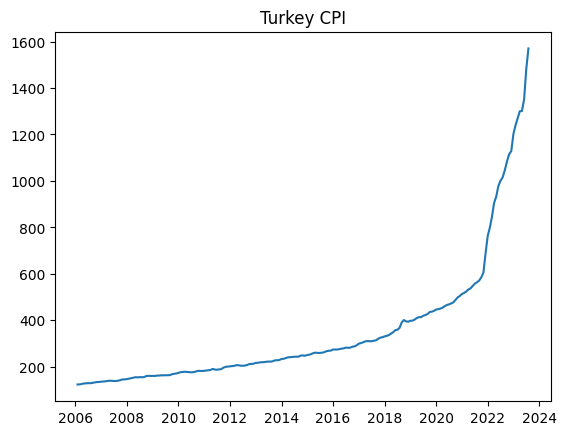

In [7]:
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure()
plt.title("Turkey CPI")

plt.plot(df)
plt.show()


In [8]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
0,1.326535
1,1.335139
2,1.337345
3,1.420659
4,1.600536
...,...
206,19.337032
207,19.719514
208,23.106042
209,26.470338


In [9]:
dates= pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)

            
df6=df6.set_index(dates)

df6["Onceki USD/TL"]=df6["USD/TL"].shift(1)
df6.iloc[0,1]=1.32
df6

,USD/TL,Onceki USD/TL
2006-02-01,1.326535,1.320000
2006-03-01,1.335139,1.326535
2006-04-01,1.337345,1.335139
2006-05-01,1.420659,1.337345
2006-06-01,1.600536,1.420659
...,...,...
2023-04-01,19.337032,19.003478
2023-05-01,19.719514,19.337032
2023-06-01,23.106042,19.719514
2023-07-01,26.470338,23.106042


In [10]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
money

,Tarih,TP_PR_ARZ13
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
206,2023-4,9.505999e+09
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10


In [11]:
#Cleaning the data

money_supply=pd.DataFrame(money)
money_supply.columns=["Tarih","Para Arzi"]
money_supply["Para Arzi"]=money_supply["Para Arzi"].astype(float)
money_supply


,Tarih,Para Arzi
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
206,2023-4,9.505999e+09
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10


In [12]:
money_supply=money_supply.set_index(dates)
money_supply["Para Arzi"]=money_supply["Para Arzi"]/1e+08
money_supply
dfn=pd.DataFrame(money_supply)
del dfn["Tarih"]
dfn["Para Arzi Onceki"]=dfn["Para Arzi"].shift(1)
dfn.iloc[0,1]=2.39
dfn


,Para Arzi,Para Arzi Onceki
2006-02-01,2.423895,2.390000
2006-03-01,2.494857,2.423895
2006-04-01,2.521919,2.494857
2006-05-01,2.751947,2.521919
2006-06-01,2.791388,2.751947
...,...,...
2023-04-01,95.059993,90.592762
2023-05-01,94.093167,95.059993
2023-06-01,108.345324,94.093167
2023-07-01,114.784753,108.345324


In [13]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,2006-2,59.78
1,2006-3,66.06
2,2006-4,72.15
3,2006-5,67.57
4,2006-6,73.20
...,...,...
206,2023-4,81.32
207,2023-5,71.98
208,2023-6,74.51
209,2023-7,85.22


In [14]:

brent1=pd.DataFrame(brent)
brent1.columns=["Tarih","Brent"]
brent1


,Tarih,Brent
0,2006-2,59.78
1,2006-3,66.06
2,2006-4,72.15
3,2006-5,67.57
4,2006-6,73.20
...,...,...
206,2023-4,81.32
207,2023-5,71.98
208,2023-6,74.51
209,2023-7,85.22


In [15]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)

df14["Brent"]=brent1["Brent"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

C:\Users\BoraKAYAPEAKUP\AppData\Local\Temp\ipykernel_1304\1501373576.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Brent
TIME,
2006-02-01,59.78
2006-03-01,66.06
2006-04-01,72.15
2006-05-01,67.57
2006-06-01,73.20
...,...
2023-04-01,81.32
2023-05-01,71.98
2023-06-01,74.51


In [16]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
206,2023-4,8.572114e+09
207,2023-5,8.804344e+09
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09


In [17]:
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
206,2023-4,85.721139
207,2023-5,88.043441
208,2023-6,95.646045
209,2023-7,98.468952


In [18]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3

C:\Users\BoraKAYAPEAKUP\AppData\Local\Temp\ipykernel_1304\2513009782.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Kredi
TIME,
2006-02-01,1.381847
2006-03-01,1.481222
2006-04-01,1.527510
2006-05-01,1.664881
2006-06-01,1.740395
...,...
2023-04-01,85.721139
2023-05-01,88.043441
2023-06-01,95.646045


In [19]:
faiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
faiz

,Tarih,TP_KTFTUK
0,2006-2,17.2975
1,2006-3,17.0080
2,2006-4,16.2075
3,2006-5,16.3000
4,2006-6,19.6700
...,...,...
206,2023-4,29.2275
207,2023-5,32.0225
208,2023-6,38.5600
209,2023-7,45.8250


In [20]:

dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
faiz=pd.DataFrame(faiz)
faiz.columns=["Tarih","Faiz"]
faiz

,Tarih,Faiz
0,2006-2,17.2975
1,2006-3,17.0080
2,2006-4,16.2075
3,2006-5,16.3000
4,2006-6,19.6700
...,...,...
206,2023-4,29.2275
207,2023-5,32.0225
208,2023-6,38.5600
209,2023-7,45.8250


In [21]:
df4=pd.DataFrame()
df4["Faiz"]=faiz["Faiz"]
df4["TIME"]=dates
df4['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df4['TIME'] =  pd.to_datetime(df4['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df4 = df4.set_index(['TIME'])
df4

C:\Users\BoraKAYAPEAKUP\AppData\Local\Temp\ipykernel_1304\2598961303.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df4['TIME'] =  pd.to_datetime(df4['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Faiz
TIME,
2006-02-01,17.2975
2006-03-01,17.0080
2006-04-01,16.2075
2006-05-01,16.3000
2006-06-01,19.6700
...,...
2023-04-01,29.2275
2023-05-01,32.0225
2023-06-01,38.5600


In [67]:
X=pd.concat([df6["Onceki USD/TL"],dfn["Para Arzi Onceki"],df14.Brent,df3.Kredi,df4["Faiz"]],axis=1)



In [28]:
y=pd.DataFrame(df["CPI"])
y["CPI"]=y["CPI"].astype(float)
y


,CPI
2006-02-01,123.84
2006-03-01,124.18
2006-04-01,125.84
2006-05-01,128.20
2006-06-01,128.63
...,...
2023-04-01,1300.04
2023-05-01,1300.60
2023-06-01,1351.59
2023-07-01,1479.84


In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [69]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()

# Modelin özetini görüntüleyin
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     9275.
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          1.30e-175
Time:                        14:50:40   Log-Likelihood:                -605.63
No. Observations:                 147   AIC:                             1223.
Df Residuals:                     141   BIC:                             1241.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               88.6675      6.983  

In [70]:
results.params

const               88.667460
Onceki USD/TL       15.892471
Para Arzi Onceki     6.196140
Brent                0.224162
Kredi                3.418008
Faiz                -0.327988
dtype: float64

In [26]:
from pmdarima.arima import auto_arima

results = auto_arima(df14, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1509.594, Time=0.35 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1444.204, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1493.404, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1421.691, Time=3.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1434.273, Time=0.74 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1423.010, Time=1.00 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1423.155, Time=1.03 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1421.362, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1445.599, Time=0.26 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

In [44]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df14.astype(float),
                                order=(0,1,0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [45]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [46]:
pred_ci['Predicted'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
pred_ci['Observed'] = df14["Brent"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Brent,upper Brent,Predicted,Observed,"Diff, %%"
2022-11-01,76.932692,109.558004,93.245348,85.61,8.918757
2022-12-01,73.999618,106.624930,90.312274,82.82,9.046455
2023-01-01,69.291639,101.916950,85.604294,83.42,2.618430
2023-02-01,71.196692,103.822004,87.509348,83.21,5.166864
2023-03-01,53.887493,86.512805,70.200149,79.19,-11.352256
2023-04-01,65.545686,98.170998,81.858342,81.32,0.662004
2023-05-01,78.001208,110.626520,94.313864,71.98,31.027874
2023-06-01,58.219236,90.844547,74.531892,74.51,0.029381
2023-07-01,55.860250,88.485562,72.172906,85.22,-15.309897
2023-08-01,63.079047,95.704359,79.391703,86.47,-8.185842


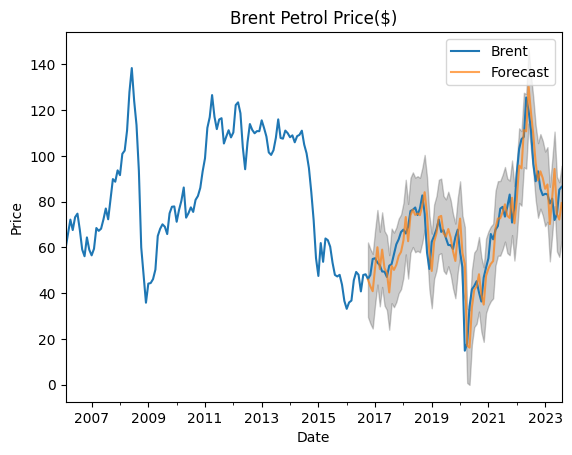

In [43]:
ax = df14['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")
plt.legend()
plt.show()

In [47]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

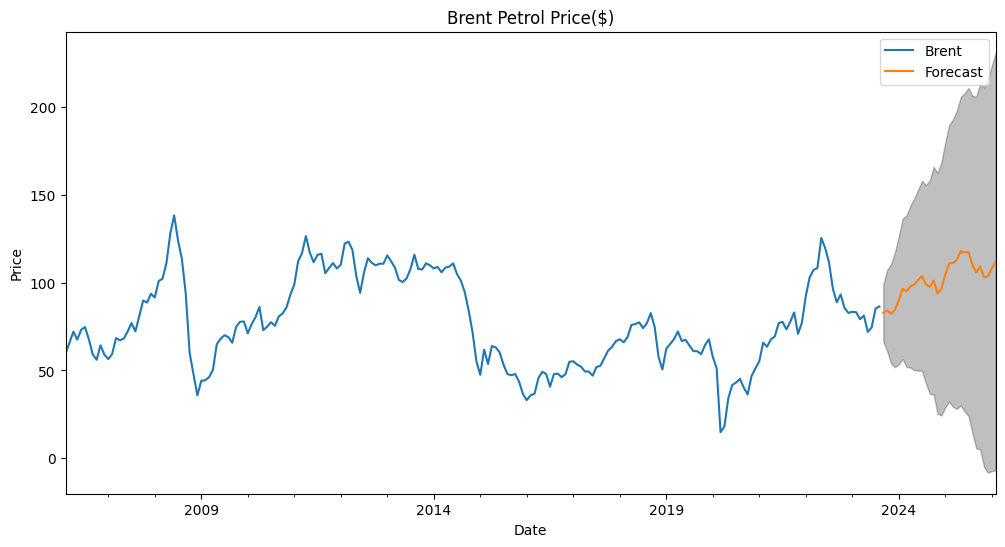

In [80]:
ax = df14.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")

plt.legend()

plt.show()

In [48]:
pred_ci['Mean'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
brenttahmin=pred_ci["Mean"]
brenttahmin=pd.DataFrame(brenttahmin)
brenttahmin.columns=["Brent"]
brenttahmin=pd.concat([df14.tail(1),brenttahmin],axis=0)
brenttahmin



,Brent
2023-08-01,86.470000
2023-09-01,82.761637
2023-10-01,84.156580
2023-11-01,82.371329
2023-12-01,84.546939
2024-01-01,89.959731
2024-02-01,96.545391
2024-03-01,95.153072
2024-04-01,97.827887
2024-05-01,99.089970


In [34]:
from pmdarima.arima import auto_arima

results = auto_arima(dfn["Para Arzi"], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=615.446, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=645.603, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.423, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=645.155, Time=0.27 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=635.592, Time=0.27 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=616.879, Time=1.16 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=616.647, Time=5.53 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=618.578, Time=2.09 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=7.51 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.106, Time=0.17 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=616.190, Time=1.06 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=615.907, Time=1.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=646.069, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=643.304, Time=0.35 sec
 ARIMA(2,1,0)(0,1,1)[12]             

In [74]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(dfn["Para Arzi Onceki"].astype(float),
                                order=(1,1,1),
                                seasonal_order=(0,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [75]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [76]:
pred_ci['Predicted'] = (pred_ci["lower Para Arzi Onceki"] + pred_ci["upper Para Arzi Onceki"])/2
pred_ci['Observed'] = dfn["Para Arzi Onceki"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Para Arzi Onceki,upper Para Arzi Onceki,Predicted,Observed,"Diff, %%"
2022-11-01,76.363208,80.447240,78.405224,77.750311,0.842328
2022-12-01,79.789154,83.873017,81.831086,79.312824,3.175100
2023-01-01,80.898899,84.982596,82.940748,82.127970,0.989648
2023-02-01,83.540276,87.623811,85.582043,84.330974,1.483523
2023-03-01,85.914933,89.998467,87.956700,86.852197,1.271705
2023-04-01,89.281282,93.364653,91.322968,90.592762,0.806031
2023-05-01,92.890070,96.973282,94.931676,95.059993,-0.134985
2023-06-01,97.779679,101.862733,99.821206,94.093167,6.087625
2023-07-01,96.514699,100.597599,98.556149,108.345324,-9.035161
2023-08-01,111.519008,115.601756,113.560382,114.784753,-1.066667


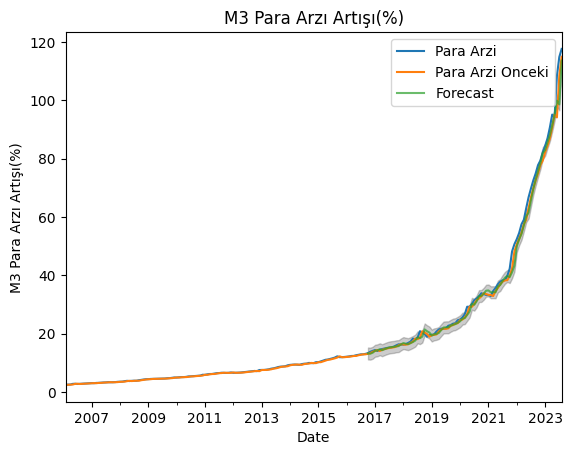

In [77]:
ax = dfn['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('M3 Para Arzı Artışı(%)')
plt.title("M3 Para Arzı Artışı(%)")
plt.legend()
plt.show()

In [78]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

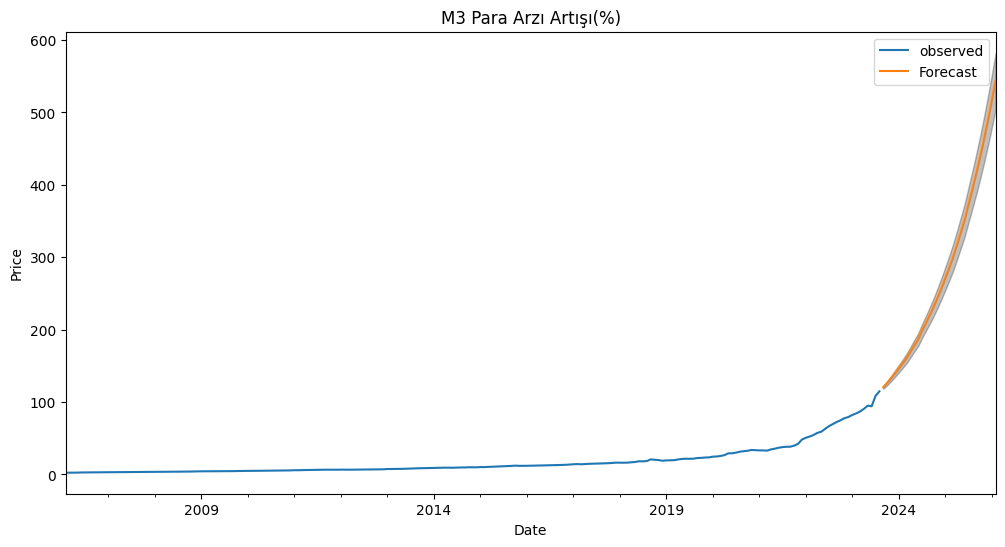

In [79]:
ax = dfn["Para Arzi Onceki"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("M3 Para Arzı Artışı(%)")

plt.legend()

plt.show()

In [81]:
import random
import numpy as np
pred_ci['Mean'] = (pred_ci["lower Para Arzi Onceki"] + pred_ci["upper Para Arzi Onceki"])/2
paraarzitahmin=pred_ci["Mean"]
paraarzitahmin=pd.concat([dfn["Para Arzi Onceki"].tail(1),paraarzitahmin])
paraarzitahmin=pd.DataFrame(paraarzitahmin)
paraarzitahmin.columns=["Para Arzi Tahmin"]



drop_percentage = random.uniform(1.01, 1.03)
drop_percentage1 = random.uniform(1.005, 1.01)
paraarzitahmin["Para Arzi Assumption 2"]=paraarzitahmin["Para Arzi Tahmin"]
paraarzitahmin["Para Arzi Assumption 3"]=paraarzitahmin["Para Arzi Tahmin"]
for i in range(0, len(paraarzitahmin)-1):
   
   paraarzitahmin["Para Arzi Assumption 2"][i+1]=paraarzitahmin["Para Arzi Assumption 2"][i]*drop_percentage
   paraarzitahmin["Para Arzi Assumption 3"][i+1]=paraarzitahmin["Para Arzi Assumption 3"][i]*drop_percentage1


paraarzitahmin

,Para Arzi Tahmin,Para Arzi Assumption 2,Para Arzi Assumption 3
2023-08-01,114.784753,114.784753,114.784753
2023-09-01,120.343514,116.355848,115.659929
2023-10-01,126.071249,117.948448,116.541777
2023-11-01,132.386959,119.562846,117.430349
2023-12-01,139.076032,121.199341,118.325696
2024-01-01,145.980097,122.858235,119.227870
2024-02-01,152.864895,124.539835,120.136922
2024-03-01,160.234036,126.244451,121.052905
2024-04-01,168.816121,127.972399,121.975873
2024-05-01,177.730609,129.723998,122.905877


In [42]:
from pmdarima.arima import auto_arima

results = auto_arima(df6, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=190.945, Time=1.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=283.960, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=209.451, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=188.989, Time=0.86 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=242.739, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=187.008, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=186.633, Time=0.30 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=187.160, Time=0.77 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=188.764, Time=3.50 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=252.549, Time=0.19 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=188.475, Time=0.47 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=188.490, Time=0.45 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=190.409, Time=1.10 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=185.542, Time=1.54 sec
 ARIMA(0,1,1)(0,1,0)[12] intercep

In [39]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df6["Onceki USD/TL"].astype(float),
                                order=(0,1,1),
                                seasonal_order=(1,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [40]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [41]:
pred_ci['Predicted'] = (pred_ci["lower Onceki USD/TL"] + pred_ci["upper Onceki USD/TL"])/2
pred_ci['Observed'] = df6["Onceki USD/TL"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Onceki USD/TL,upper Onceki USD/TL,Predicted,Observed,"Diff, %%"
2022-11-01,17.815536,19.327250,18.571393,18.598067,-0.143422
2022-12-01,18.260581,19.772294,19.016438,18.624382,2.105067
2023-01-01,18.136638,19.648352,18.892495,18.670545,1.188768
2023-02-01,17.556341,19.068055,18.312198,18.791373,-2.549974
2023-03-01,18.178513,19.690226,18.934369,18.857210,0.409177
2023-04-01,18.666006,20.177720,19.421863,19.003478,2.201621
2023-05-01,18.393115,19.904829,19.148972,19.337032,-0.972537
2023-06-01,19.068911,20.580625,19.824768,19.719514,0.533756
2023-07-01,19.360950,20.872663,20.116806,23.106042,-12.937030
2023-08-01,24.464322,25.976036,25.220179,26.470338,-4.722868


In [42]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

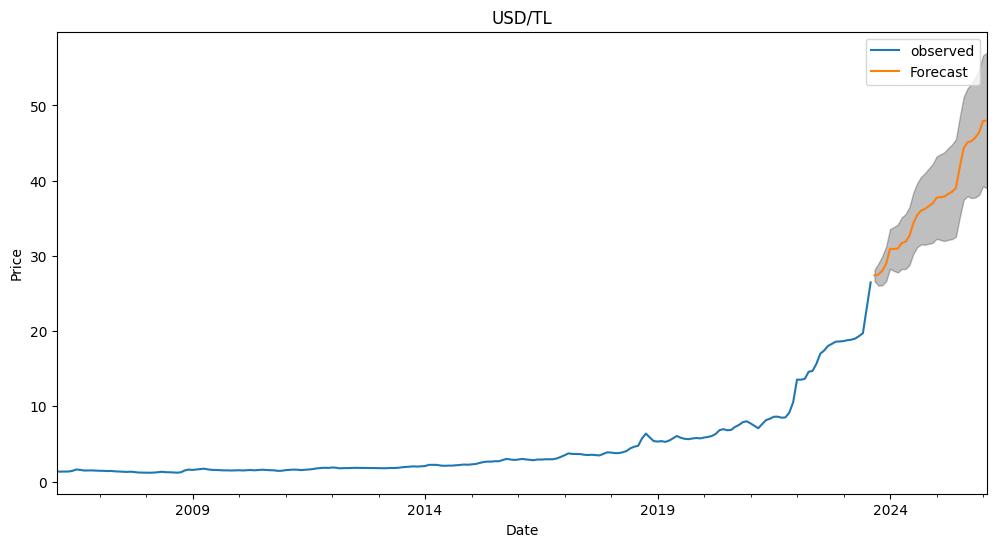

In [325]:
ax = df6["Onceki USD/TL"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("USD/TL")

plt.legend()

plt.show()

In [43]:
pred_ci['Mean'] = (pred_ci["lower Onceki USD/TL"] + pred_ci["upper Onceki USD/TL"])/2
usdtahmin=pred_ci["Mean"]
usdtahmin=pd.concat([df6["Onceki USD/TL"].tail(1),usdtahmin])
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USD Tahmin"]

drop_percentage = random.uniform(1.001, 1.01)
usdtahmin["USD Tahmin Assumption 2"]=usdtahmin["USD Tahmin"]
for i in range(0, len(usdtahmin)-1):
   
   usdtahmin["USD Tahmin Assumption 2"][i+1]=usdtahmin["USD Tahmin Assumption 2"][i]*drop_percentage


usdtahmin.iloc[0,:]=[27.07,27.07]
usdtahmin

,USD Tahmin,USD Tahmin Assumption 2
2023-08-01,27.070000,27.070000
2023-09-01,27.398001,26.682992
2023-10-01,27.515092,26.897355
2023-11-01,28.029683,27.113440
2023-12-01,28.958519,27.331260
2024-01-01,30.926491,27.550831
2024-02-01,30.919882,27.772166
2024-03-01,30.974406,27.995278
2024-04-01,31.686534,28.220184
2024-05-01,31.898206,28.446896


In [49]:
from pmdarima.arima import auto_arima

results = auto_arima(df3, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=437.234, Time=1.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=509.540, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=466.494, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=470.859, Time=0.34 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=481.050, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=438.459, Time=1.33 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=438.705, Time=3.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=441.108, Time=0.69 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=438.840, Time=4.64 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=463.632, Time=0.35 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=437.567, Time=1.61 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=436.033, Time=1.12 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=482.795, Time=0.25 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=437.622, Time=1.33 sec
 ARIMA(1,1,2)(0,1,2)[12]         

In [49]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df3.astype(float),
                                order=(3,1,0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [50]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [51]:
pred_ci['Predicted'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
pred_ci['Observed'] = df3["Kredi"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Kredi,upper Kredi,Predicted,Observed,"Diff, %%"
2022-11-01,68.408897,71.185731,69.797314,69.536996,0.374359
2022-12-01,69.698695,72.475530,71.087113,72.851339,-2.421680
2023-01-01,72.576774,75.353609,73.965191,75.079809,-1.484577
2023-02-01,75.600270,78.377105,76.988688,77.112692,-0.160810
2023-03-01,79.135550,81.912385,80.523968,82.109915,-1.931494
2023-04-01,83.953773,86.730608,85.342190,85.721139,-0.442071
2023-05-01,87.394139,90.170974,88.782556,88.043441,0.839489
2023-06-01,90.039143,92.815978,91.427561,95.646045,-4.410516
2023-07-01,97.539927,100.316762,98.928344,98.468952,0.466535
2023-08-01,98.949876,101.726711,100.338294,99.283032,1.062883


In [52]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

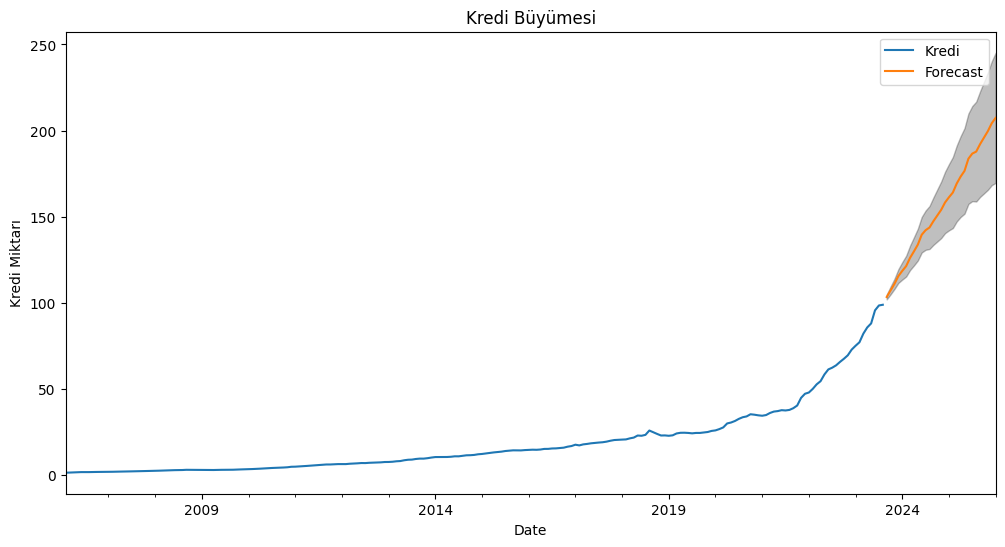

In [65]:
ax = df3.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Kredi Miktarı')
plt.title("Kredi Büyümesi")

plt.legend()

plt.show()

In [53]:
import random
pred_ci['Mean'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
kreditahmin=pred_ci["Mean"]
kreditahmin=pd.concat([df3["Kredi"].tail(1),kreditahmin])
kreditahmin=pd.DataFrame(kreditahmin)
kreditahmin.columns=["Kredi Tahmin"]

drop_percentage = random.uniform(1.005, 1.01)
drop_percentage1=random.uniform(0.005, 0.01)
kreditahmin["Kredi Tahmin Assumption 2"]=kreditahmin["Kredi Tahmin"]
kreditahmin["Kredi Tahmin Assumption 3"]=kreditahmin["Kredi Tahmin"]
for i in range(0, len(kreditahmin)-1):
   
   kreditahmin["Kredi Tahmin Assumption 2"][i+1]=kreditahmin["Kredi Tahmin Assumption 2"][i]*drop_percentage
   kreditahmin["Kredi Tahmin Assumption 3"][i+1]=kreditahmin["Kredi Tahmin Assumption 3"][i]*(1-drop_percentage1)


kreditahmin

,Kredi Tahmin,Kredi Tahmin Assumption 2,Kredi Tahmin Assumption 3
2023-08-01,99.283032,99.283032,99.283032
2023-09-01,103.897010,100.052319,98.724913
2023-10-01,107.740990,100.827568,98.169933
2023-11-01,111.872807,101.608823,97.618071
2023-12-01,116.545383,102.396132,97.069313
2024-01-01,119.597047,103.189541,96.523639
2024-02-01,122.573296,103.989098,95.981032
2024-03-01,127.495161,104.794851,95.441476
2024-04-01,131.337469,105.606846,94.904953
2024-05-01,135.420488,106.425133,94.371446


In [54]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df4.astype(float),
                                order=(2,1,0),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\BoraKAYAPEAKUP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [55]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [56]:
pred_ci['Predicted'] = (pred_ci["lower Faiz"] + pred_ci["upper Faiz"])/2
pred_ci['Observed'] = df4["Faiz"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Faiz,upper Faiz,Predicted,Observed,"Diff, %%"
2022-11-01,26.851230,32.114422,29.482826,29.6650,-0.614106
2022-12-01,26.957838,32.221030,29.589434,28.7180,3.034452
2023-01-01,25.209080,30.472272,27.840676,28.6800,-2.926514
2023-02-01,25.646298,30.909490,28.277894,28.2550,0.081025
2023-03-01,25.210939,30.474087,27.842513,26.5080,5.034378
2023-04-01,23.175552,28.438700,25.807126,29.2275,-11.702588
2023-05-01,28.833390,34.096537,31.464963,32.0225,-1.741078
2023-06-01,30.642771,35.905918,33.274345,38.5600,-13.707613
2023-07-01,39.605465,44.868612,42.237038,45.8250,-7.829703
2023-08-01,46.938225,52.201372,49.569798,45.5400,8.848920


In [57]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

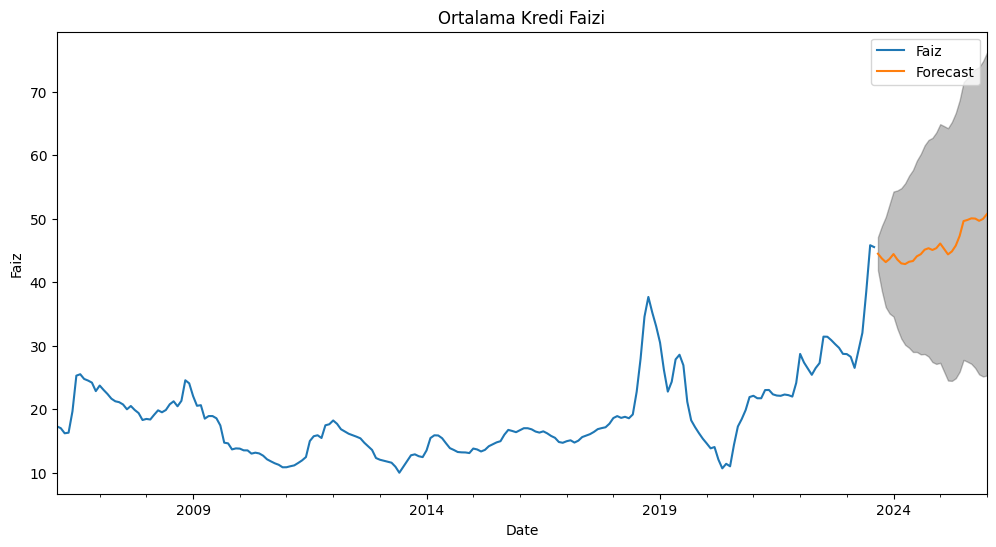

In [71]:
ax = df4.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Faiz')
plt.title("Ortalama Kredi Faizi")

plt.legend()

plt.show()

In [58]:
pred_ci['Mean'] = (pred_ci["lower Faiz"] + pred_ci["upper Faiz"])/2
faiztahmin=pred_ci["Mean"]
faiztahmin=pd.concat([df4["Faiz"].tail(1),faiztahmin])
faiztahmin

2023-08-01    45.540000
2023-09-01    44.491793
2023-10-01    43.740928
2023-11-01    43.173535
2023-12-01    43.676446
2024-01-01    44.438096
2024-02-01    43.558837
2024-03-01    42.967104
2024-04-01    42.861059
2024-05-01    43.221763
2024-06-01    43.344455
2024-07-01    44.083273
2024-08-01    44.414376
2024-09-01    45.123427
2024-10-01    45.354172
2024-11-01    45.080053
2024-12-01    45.363900
2025-01-01    46.100060
2025-02-01    45.248151
2025-03-01    44.386026
2025-04-01    44.849319
2025-05-01    45.769504
2025-06-01    47.298729
2025-07-01    49.631209
2025-08-01    49.809946
2025-09-01    50.060327
2025-10-01    50.022538
2025-11-01    49.674219
2025-12-01    49.969425
2026-01-01    50.729755
2026-02-01    49.891250
dtype: float64

In [59]:
kreditahmin["Kredi Tahmin Assumption 2"]

2023-08-01     99.283032
2023-09-01    100.052319
2023-10-01    100.827568
2023-11-01    101.608823
2023-12-01    102.396132
2024-01-01    103.189541
2024-02-01    103.989098
2024-03-01    104.794851
2024-04-01    105.606846
2024-05-01    106.425133
2024-06-01    107.249761
2024-07-01    108.080778
2024-08-01    108.918235
2024-09-01    109.762180
2024-10-01    110.612665
2024-11-01    111.469739
2024-12-01    112.333455
2025-01-01    113.203862
2025-02-01    114.081015
2025-03-01    114.964963
2025-04-01    115.855761
2025-05-01    116.753462
2025-06-01    117.658118
2025-07-01    118.569783
2025-08-01    119.488513
2025-09-01    120.414361
2025-10-01    121.347384
2025-11-01    122.287635
2025-12-01    123.235173
2026-01-01    124.190052
2026-02-01    125.152330
Name: Kredi Tahmin Assumption 2, dtype: float64

In [82]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()










res2=[]
res3=[]
res4=[]
res5=[]
res6=[]
res7=[]
for i in range(31):
    res2.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res3.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Assumption 2"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 2"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res4.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 2"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res5.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin Assumption 2"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 2"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res6.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin Assumption 2"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Assumption 2"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 3"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res7.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin Assumption 2"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Assumption 3"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 3"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i]

)


df9=pd.DataFrame()
dates=pd.date_range('2023-08-01','2026-03-01' , freq='1M')-pd.offsets.MonthBegin(1)
df9["Inflation"]=res2
df9["Assumption 2 Inflation"]=res3
df9["Assumption 3 Inflation"]=res4
df9["Assumption 4 Inflation"]=res5
df9["Assumption 5 Inflation"]=res6
df9["Assumption 6 Inflation"]=res7
df9['TIME']=dates
df9=df9.set_index(dates)
del df9['TIME']
df9

,Inflation,Assumption 2 Inflation,Assumption 3 Inflation,Assumption 4 Inflation,Assumption 5 Inflation,Assumption 6 Inflation
2023-08-01,1573.895942,1573.895942,1573.895942,1573.895942,1573.895942,1573.895942
2023-09-01,1628.834694,1590.985376,1615.693513,1604.330257,1575.085036,1570.773020
2023-10-01,1679.883131,1605.922986,1656.253000,1646.435629,1587.021797,1578.305867
2023-11-01,1741.102763,1626.560386,1706.020387,1691.459023,1598.358603,1585.145353
2023-12-01,1813.604349,1654.475618,1765.242100,1739.380933,1610.407342,1592.601837
2024-01-01,1899.052975,1699.705693,1842.971993,1789.324419,1623.274012,1600.779761
2024-02-01,1953.544602,1714.517624,1890.023672,1839.998677,1637.120999,1609.839934
2024-03-01,2016.776296,1728.582225,1939.186461,1891.840766,1649.266624,1617.099078
2024-04-01,2095.036978,1754.016087,2007.089512,1952.000640,1662.348063,1625.192742
2024-05-01,2167.756784,1771.194746,2068.650440,2013.800591,1675.145303,1632.899266


In [83]:
dff=pd.concat([df["CPI"].head(210),df9["Inflation"]],axis=0)
dff=pd.DataFrame(dff)
dff.columns=["CPI"]



dfas2=pd.concat([df["CPI"].head(210),df9["Assumption 2 Inflation"]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["CPI"]
dfas2


dfas3=pd.concat([df["CPI"].head(210),df9["Assumption 3 Inflation"]],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=["CPI"]

dfas4=pd.concat([df["CPI"].head(210),df9["Assumption 4 Inflation"]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=["CPI"]

dfas5=pd.concat([df["CPI"].head(210),df9["Assumption 5 Inflation"]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=["CPI"]

dfas6=pd.concat([df["CPI"].head(210),df9["Assumption 6 Inflation"]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=["CPI"]


In [84]:
import pandas as pd

# Örnek DataFrame oluşturalım (gerçek verilere göre değiştirin)
# Diyelim ki veriler 'tufe' sütununda ve 'tarih' sütununda saklanıyor




# 12 ay önceki tüfe değerlerini içeren bir sütun ekleyin
dff['onceki_yil_tufe'] = dff['CPI'].shift(12)
dfas2['onceki_yil_tufe'] = dfas2['CPI'].shift(12)
dfas3['onceki_yil_tufe'] = dfas3['CPI'].shift(12)
dfas4['onceki_yil_tufe'] = dfas4['CPI'].shift(12)
dfas5['onceki_yil_tufe'] = dfas5['CPI'].shift(12)
dfas6['onceki_yil_tufe'] = dfas6['CPI'].shift(12)

# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
dff['yillik_enflasyon_orani'] = ((dff['CPI'] / dff['onceki_yil_tufe']) - 1) * 100
dfas2['yillik_enflasyon_orani'] = ((dfas2['CPI'] / dfas2['onceki_yil_tufe']) - 1) * 100
dfas3['yillik_enflasyon_orani'] = ((dfas3['CPI'] / dfas3['onceki_yil_tufe']) - 1) * 100
dfas4['yillik_enflasyon_orani'] = ((dfas4['CPI'] / dfas4['onceki_yil_tufe']) - 1) * 100
dfas5['yillik_enflasyon_orani'] = ((dfas5['CPI'] / dfas5['onceki_yil_tufe']) - 1) * 100
dfas6['yillik_enflasyon_orani'] = ((dfas6['CPI'] / dfas6['onceki_yil_tufe']) - 1) * 100

# NaN değerleri (ilk 12 ay) veriden çıkarın
dff.dropna(inplace=True)
dfas2.dropna(inplace=True)
dfas3.dropna(inplace=True)
dfas4.dropna(inplace=True)
dfas5.dropna(inplace=True)
dfas6.dropna(inplace=True)

# Sonuçları başka bir DataFrame'e kopyalayın (gerekirse)
result_df = dff[['yillik_enflasyon_orani']].copy()

result_df


,yillik_enflasyon_orani
2007-02-01,10.158269
2007-03-01,10.863263
2007-04-01,10.719962
2007-05-01,9.227769
2007-06-01,8.598305
...,...
2025-10-01,60.331561
2025-11-01,61.136800
2025-12-01,61.923164
2026-01-01,62.856965


In [64]:
dfas6

,CPI,onceki_yil_tufe,yillik_enflasyon_orani
2007-02-01,136.420000,123.840000,10.158269
2007-03-01,137.670000,124.180000,10.863263
2007-04-01,139.330000,125.840000,10.719962
2007-05-01,140.030000,128.200000,9.227769
2007-06-01,139.690000,128.630000,8.598305
...,...,...,...
2025-10-01,1778.168334,1670.874884,6.421393
2025-11-01,1786.393709,1677.673104,6.480440
2025-12-01,1796.039847,1686.599185,6.488836
2026-01-01,1806.611736,1696.718648,6.476801


In [85]:
dfas2=dfas2.head(228)
dfas3=dfas3.head(228)
dfas4=dfas4.head(228)
dfas5=dfas5.head(228)
dfas6=dfas6.head(228)

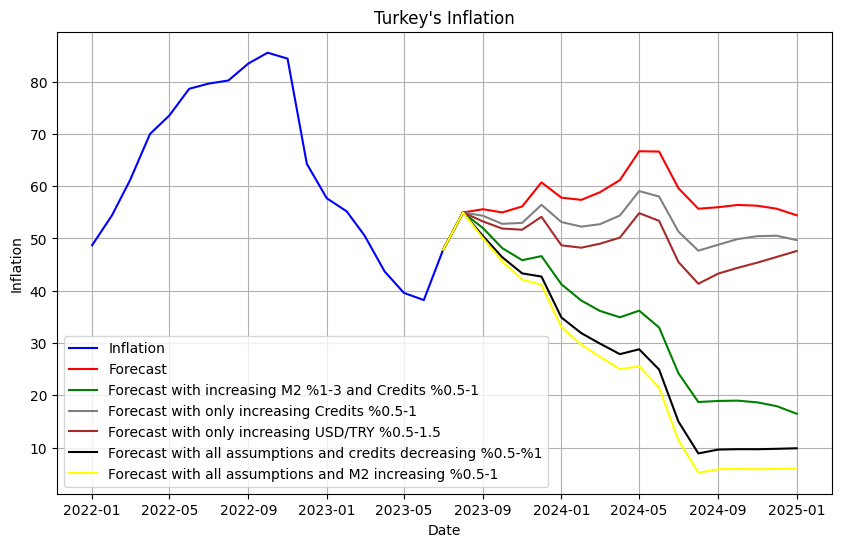

In [86]:
dates=pd.date_range('2008-02-01','2026-02-01' , freq='1M')-pd.offsets.MonthBegin(1)



# Grafik çizdirelim
plt.figure(figsize=(10, 6))
plt.plot(dff.iloc[179:198]["yillik_enflasyon_orani"], label='Inflation', color='blue')
plt.plot(dff.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast', color='red')
plt.plot(dfas2.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with increasing M2 %1-3 and Credits %0.5-1', color='green')
plt.plot(dfas3.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with only increasing Credits %0.5-1', color='gray')
plt.plot(dfas4.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with only increasing USD/TRY %0.5-1.5', color='brown')
plt.plot(dfas5.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with all assumptions and credits decreasing %0.5-%1', color='black')
plt.plot(dfas6.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with all assumptions and M2 increasing %0.5-1', color='yellow')

plt.xlabel('Date')
plt.ylabel('Inflation')
plt.title("Turkey's Inflation")
plt.legend()
plt.grid(True)
plt.show()


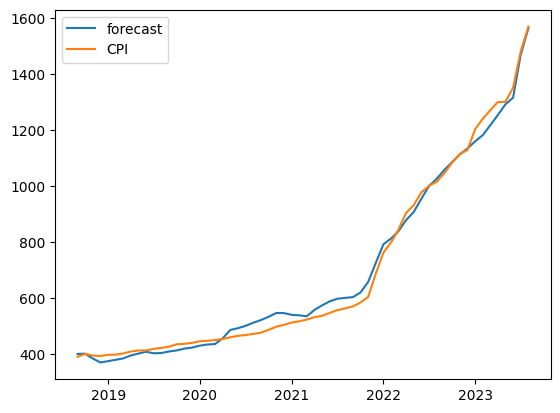

In [87]:
res6=[]
for i in range(-211,0):
    res6.append(results.params["const"]+results.params["Onceki USD/TL"]*df6["Onceki USD/TL"][i]+results.params["Para Arzi Onceki"]*dfn["Para Arzi Onceki"][i]+results.params["Kredi"]*df3["Kredi"][i]+results.params["Brent"]*df14["Brent"][i]+results.params["Faiz"]*df4["Faiz"][i])
res6=pd.DataFrame(res6)
res6=res6.set_index(df.index)
res6.columns=["CPI"]
plt.plot(res6.tail(60),label="forecast")
plt.plot(df.tail(60),label="CPI")
plt.legend()

In [88]:
res6['onceki_yil_tufe'] = res6['CPI'].shift(12)


# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
res6['yillik_enflasyon_orani'] = ((res6['CPI'] / res6['onceki_yil_tufe']) - 1) * 100


# NaN değerleri (ilk 12 ay) veriden çıkarın
res6.dropna(inplace=True)
res6

,CPI,onceki_yil_tufe,yillik_enflasyon_orani
2007-02-01,142.344141,136.904471,3.973333
2007-03-01,144.180877,139.060698,3.681974
2007-04-01,145.030177,141.423039,2.550602
2007-05-01,144.854427,141.038310,2.705730
2007-06-01,146.175115,144.202484,1.367959
...,...,...,...
2023-04-01,1253.643217,878.783174,42.656716
2023-05-01,1291.551046,907.319187,42.348036
2023-06-01,1316.047723,955.216147,37.774861
2023-07-01,1467.843040,1000.043859,46.777866


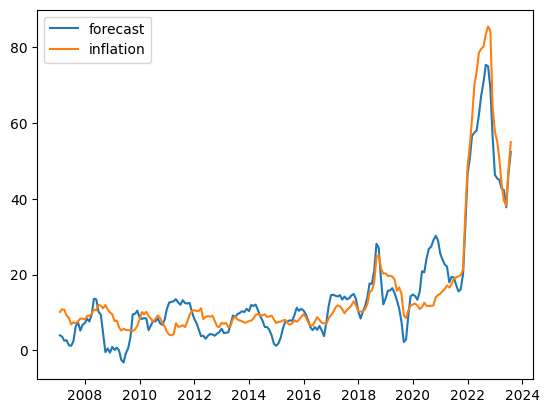

In [89]:
plt.plot(res6["yillik_enflasyon_orani"],label="forecast")
plt.plot(result_df.head(199),label="inflation")
plt.legend()

In [90]:
dff["Onceki Ay TUFE"]=dff["CPI"].shift(1)

In [91]:
res6["Onceki Ay TUFE"]=res6["CPI"].shift(1)
res6.iloc[0,3]=1421
res6["Aylık Enflasyon Tahmin"]=((res6["CPI"]/res6["Onceki Ay TUFE"]-1)*100)
res6["Gerceklesen Aylık Enflasyon"]=((dff["CPI"].head(219)/dff["Onceki Ay TUFE"].head(219)-1)*100)
res6

,CPI,onceki_yil_tufe,yillik_enflasyon_orani,Onceki Ay TUFE,Aylık Enflasyon Tahmin,Gerceklesen Aylık Enflasyon
2007-02-01,142.344141,136.904471,3.973333,1421.000000,-89.982819,NaN
2007-03-01,144.180877,139.060698,3.681974,142.344141,1.290349,0.916288
2007-04-01,145.030177,141.423039,2.550602,144.180877,0.589052,1.205782
2007-05-01,144.854427,141.038310,2.705730,145.030177,-0.121182,0.502404
2007-06-01,146.175115,144.202484,1.367959,144.854427,0.911735,-0.242805
...,...,...,...,...,...,...
2023-04-01,1253.643217,878.783174,42.656716,1216.212897,3.077612,2.385509
2023-05-01,1291.551046,907.319187,42.348036,1253.643217,3.023813,0.043076
2023-06-01,1316.047723,955.216147,37.774861,1291.551046,1.896687,3.920498
2023-07-01,1467.843040,1000.043859,46.777866,1316.047723,11.534180,9.488824


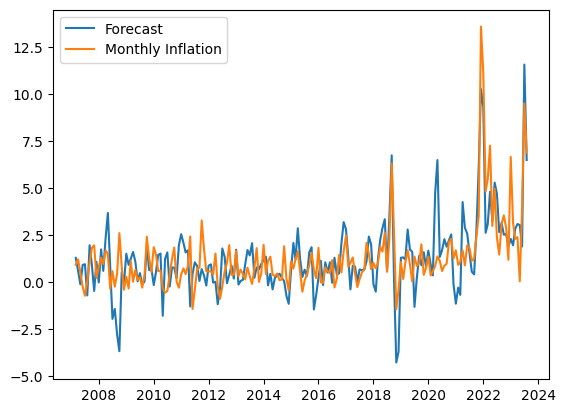

In [297]:
plt.plot(res6["Aylık Enflasyon Tahmin"].tail(198),label="Forecast")
plt.plot(res6["Gerceklesen Aylık Enflasyon"].tail(198),label="Monthly Inflation")
plt.legend()